In [133]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader, Dataset, IterableDataset
from torch.utils.data import random_split
from torch import optim
from fbprophet import Prophet
import math
from math import sqrt
import time 
%matplotlib inline

In [134]:
def get_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
print(get_device())

cuda


In [135]:
def RSE(pred, true):
    return np.sqrt(np.sum((true-pred)**2)) / np.sqrt(np.sum((true-true.mean())**2))

def CORR(pred, true):
    u = ((true-true.mean(0))*(pred-pred.mean(0))).sum(0) 
    d = np.sqrt(((true-true.mean(0))**2*(pred-pred.mean(0))**2).sum(0))
    return (u/d).mean(-1)

def MAE(pred, true):
    return np.mean(np.abs(pred-true))

def MSE(pred, true):
    return np.mean((pred-true)**2)

def RMSE(pred, true):
    return np.sqrt(MSE(pred, true))

def MAPE(pred, true):
    return np.mean(np.abs((pred - true) / true))

def MSPE(pred, true):
    return np.mean(np.square((pred - true) / true))

def metric(pred, true):
    mae = MAE(pred, true)
    mse = MSE(pred, true)
    rmse = RMSE(pred, true)
    mape = MAPE(pred, true)
    mspe = MSPE(pred, true)
    
    return mae,mse,rmse,mape,mspe

In [136]:
class StandardScaler():
    def __init__(self):
        self.mean = 0.
        self.std = 1.
    
    def fit(self, data):
        self.mean = data.mean(0)
        self.std = data.std(0)

    def transform(self, data):
        mean = torch.from_numpy(self.mean).type_as(data).to(data.device) if torch.is_tensor(data) else self.mean
        std = torch.from_numpy(self.std).type_as(data).to(data.device) if torch.is_tensor(data) else self.std
        return (data - mean) / std

    def inverse_transform(self, data):
        mean = torch.from_numpy(self.mean).type_as(data).to(data.device) if torch.is_tensor(data) else self.mean
        std = torch.from_numpy(self.std).type_as(data).to(data.device) if torch.is_tensor(data) else self.std
        return (data * std) + mean

In [137]:
class EarlyStopping:
    def __init__(self, patience, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0


### dataset classes

In [185]:
def get_date_repr(df_stamp, marker):
    
    df_stamp['year'] = df_stamp.date.apply(lambda row:row.year,1)
    df_stamp['month'] = df_stamp.date.apply(lambda row:row.month,1)
    df_stamp['day'] = df_stamp.date.apply(lambda row:row.day,1)
    df_stamp['weekday'] = df_stamp.date.apply(lambda row:row.weekday(),1)
    df_stamp['hour'] = df_stamp.date.apply(lambda row:row.hour,1)
    df_stamp['minute'] = df_stamp.date.apply(lambda row:row.minute,1)
    df_stamp['minute'] = df_stamp.minute.map(lambda x:x//15)
    freq_map = {
        'y':[],'m':['month'],'w':['month'],'d':['month','day','weekday'],
        'b':['month','day','weekday'],'h':['month','day','weekday','hour'],
        't':['month','day','weekday','hour','minute'],
    }
    return df_stamp[freq_map[marker]].values

In [186]:
class EttDataset(Dataset):
    def __init__(self, data, flag=0):
        self.seq_len = seq_len
        self.label_len = label_len
        self.pred_len = out_len
        self.flag = flag
        self.data = data
        scaler = StandardScaler()
        
        border1s = [0, 12*30*24 - self.seq_len, 12*30*24+4*30*24 - self.seq_len]
        border2s = [12*30*24, 12*30*24+4*30*24, 12*30*24+8*30*24]
        border1 = border1s[self.flag]
        border2 = border2s[self.flag]
        
        cols_data = self.data.columns[1:]
        df_data = self.data[cols_data]
        
        train_data = df_data[border1s[0]:border2s[0]]
        scaler.fit(train_data.values)
        df_data = scaler.transform(df_data.values)
        self.df_stamp = self.data[['date']][border1:border2]
        self.df_stamp['date'] = pd.to_datetime(self.df_stamp.date)
        self.data_stamp =  get_date_repr(self.df_stamp, 'h')
        
        data_vals = df_data #.values
        self.data_y = data_vals[border1:border2]
        self.data_x = data_vals[border1:border2]
        

    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len 
        r_end = r_begin + self.label_len + self.pred_len
        
        #print(self.data_stamp)
        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]

        return seq_x, seq_y, seq_x_mark, seq_y_mark
    
    def get_df(self, index):
        df = pd.DataFrame()
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end #- self.label_len 
        r_end = r_begin + self.pred_len # + self.label_len 
        df['ds'] = self.df_stamp['date'].iloc[r_begin:r_end]
        df['y'] =  self.data_y[r_begin:r_end][:,6]
        
        return df

    
    def __len__(self):
        return len(self.data_x) - self.seq_len- self.pred_len + 1

In [187]:
class UnivarDataset(Dataset): 
    def __init__(self, data, freq, flag=0):
        self.seq_len = seq_len
        self.label_len = label_len
        self.pred_len = out_len
        self.flag = flag
        self.data = data
        self.freq = freq
        l = len(data)
        start_of_train = int(l*0.8)
        end_of_train = int(l*0.9) 
        
        border1s = [0, start_of_train - self.seq_len, end_of_train - self.seq_len ]
        border2s = [start_of_train, end_of_train, l]
        
        border1 = border1s[self.flag]
        border2 = border2s[self.flag]
        
        cols_data = self.data.columns[1:]
        df_data = self.data[cols_data]
        
        self.df_stamp = self.data[['ds']][border1:border2]
        self.df_stamp['date'] = pd.to_datetime(self.df_stamp.ds)
        self.data_stamp =  get_date_repr(self.df_stamp, self.freq)           
        data_vals = df_data.values
        self.data_y = data_vals[border1:border2]
        self.data_x = data_vals[border1:border2]
        

    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len 
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]

        return seq_x, seq_y, seq_x_mark, seq_y_mark
    
    def get_df(self, index):
    
        df = pd.DataFrame()
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end #- self.label_len 
        r_end = r_begin + self.pred_len # + self.label_len 
        df['ds'] = self.df_stamp['ds'].iloc[r_begin:r_end]
        df['y'] =  self.data_y[r_begin:r_end]
        
        return df

    
    def __len__(self):
        return len(self.data_x) - self.seq_len- self.pred_len + 1

## Model classes

### Embedding

In [184]:
class FixedEmbedder(nn.Module):
    def __init__(self, c_in, d_model):
        super(FixedEmbedder, self).__init__()
        
        w = torch.zeros(c_in, d_model).float()
        w.require_grad = False

        position = torch.arange(0, c_in).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()

        w[:, 0::2] = torch.sin(position * div_term)
        w[:, 1::2] = torch.cos(position * div_term)

        self.emb = nn.Embedding(c_in, d_model)
        self.emb.weight = nn.Parameter(w, requires_grad=False)

    def forward(self, x):
        return self.emb(x).detach()

class Embedder(nn.Module):
    def __init__(self, c_in, d_model, freq='h', dropout=0.1):
        super(Embedder, self).__init__()
        self.d_model = d_model
        self.c_in = c_in
        self.freq = freq
        self.dropout = nn.Dropout(p=dropout)
        self.conv1 = nn.Conv1d(in_channels=self.c_in, out_channels=self.d_model, kernel_size=3, padding=1, padding_mode='circular')
        minute_size = 4
        hour_size = 24
        weekday_size = 7
        day_size = 32
        month_size = 13
        if self.freq == 'h':
            self.hour_embed = FixedEmbedder(hour_size, d_model)
        self.weekday_embed = FixedEmbedder(weekday_size, d_model)
        self.day_embed = FixedEmbedder(day_size, d_model)
        self.month_embed = FixedEmbedder(month_size, d_model)
        
    def forward(self, x, x_mark):
        # value
        value_embedding = self.conv1(x.permute(0, 2, 1)).transpose(1,2)
        
        # position
        max_len=10000
        temp = torch.zeros(max_len, self.d_model).float()
        temp.require_grad = False
        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, self.d_model, 2).float() * -(math.log(10000.0) / self.d_model)).exp()
        temp[:, 0::2] = torch.sin(position * div_term)
        temp[:, 1::2] = torch.cos(position * div_term)
        temp = temp.unsqueeze(0)
        position_embedding = temp[:, :x.size(1)]
       
        # timestamp
        x1 = x_mark.long()
        if self.freq == 'h':
            hour_x = self.hour_embed(x1[:,:,3])
        else:
            hour_x = 0
        if self.freq == 'h' or self.freq == 'd':
            day_x = self.day_embed(x1[:,:,1])
            month_x = self.month_embed(x1[:,:,0])
            weekday_x = self.weekday_embed(x1[:,:,2])
        else:
            month_x = self.day_embed(x1[:,:,1])
            weekday_x = 0
            day_x = 0
        
        temporal_embedding = hour_x + weekday_x + day_x + month_x
        
        device = get_device()
        
        x = value_embedding + temporal_embedding + position_embedding.to(device) 
        
        return self.dropout(x)

### Attention

In [147]:
class TriangularCausalMask():
    def __init__(self, B, L, device="cpu"):
        mask_shape = [B, 1, L, L]
        with torch.no_grad():
            self._mask = torch.triu(torch.ones(mask_shape, dtype=torch.bool), diagonal=1).to(device)

    @property
    def mask(self):
        return self._mask

In [148]:
class FullAttention(nn.Module):
    def __init__(self, mask_flag=True, factor=5, scale=None, attention_dropout=0.1, output_attention=False):
        super(FullAttention, self).__init__()
        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)
        
    def forward(self, queries, keys, values, attn_mask):
        B, L, H, E = queries.shape
        _, S, _, D = values.shape
        scale = self.scale or 1./sqrt(E)

        scores = torch.einsum("blhe,bshe->bhls", queries, keys)
        if self.mask_flag:
            if attn_mask is None:
                attn_mask = TriangularCausalMask(B, L, device=queries.device)

            scores.masked_fill_(attn_mask.mask, -np.inf)

        A = self.dropout(torch.softmax(scale * scores, dim=-1))
        V = torch.einsum("bhls,bshd->blhd", A, values)
        
        if self.output_attention:
            return (V.contiguous(), A)
        else:
            return (V.contiguous(), None)
        
class AttentionLayer(nn.Module):
    def __init__(self, attention, d_model, n_heads, d_keys=None,
                 d_values=None):
        super(AttentionLayer, self).__init__()

        d_keys = d_keys or (d_model//n_heads)
        d_values = d_values or (d_model//n_heads)

        self.inner_attention = attention
        self.query_projection = nn.Linear(d_model, d_keys * n_heads)
        self.key_projection = nn.Linear(d_model, d_keys * n_heads)
        self.value_projection = nn.Linear(d_model, d_values * n_heads)
        self.out_projection = nn.Linear(d_values * n_heads, d_model)
        self.n_heads = n_heads

    def forward(self, queries, keys, values, attn_mask):
        B, L, _ = queries.shape
        _, S, _ = keys.shape
        H = self.n_heads

        queries = self.query_projection(queries).view(B, L, H, -1)
        keys = self.key_projection(keys).view(B, S, H, -1)
        values = self.value_projection(values).view(B, S, H, -1)

        out, attn = self.inner_attention(
            queries,
            keys,
            values,
            attn_mask
        )
        out = out.view(B, L, -1)

        return self.out_projection(out), attn

In [149]:
class ProbMask():
    def __init__(self, B, H, L, index, scores, device="cpu"):
        _mask = torch.ones(L, scores.shape[-1], dtype=torch.bool).to(device).triu(1)
        _mask_ex = _mask[None, None, :].expand(B, H, L, scores.shape[-1])
        indicator = _mask_ex[torch.arange(B)[:, None, None],
                             torch.arange(H)[None, :, None],
                             index, :].to(device)
        self._mask = indicator.view(scores.shape).to(device)
    
    @property
    def mask(self):
        return self._mask
    
class ProbAttention(nn.Module):
    def __init__(self, mask_flag=True, factor=5, scale=None, attention_dropout=0.1, output_attention=False):
        super(ProbAttention, self).__init__()
        self.factor = factor
        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)
        
    def _prob_QK(self, Q, K, sample_k, n_top): # n_top: c*ln(L_q)
        # Q [B, H, L, D]
        B, H, L_K, E = K.shape
        _, _, L_Q, _ = Q.shape

        # calculate the sampled Q_K
        K_expand = K.unsqueeze(-3).expand(B, H, L_Q, L_K, E)
        index_sample = torch.randint(L_K, (L_Q, sample_k)) # real U = U_part(factor*ln(L_k))*L_q
        K_sample = K_expand[:, :, torch.arange(L_Q).unsqueeze(1), index_sample, :]
        Q_K_sample = torch.matmul(Q.unsqueeze(-2), K_sample.transpose(-2, -1)).squeeze()

        # find the Top_k query with sparisty measurement
        M = Q_K_sample.max(-1)[0] - torch.div(Q_K_sample.sum(-1), L_K)
        M_top = M.topk(n_top, sorted=False)[1]

        # use the reduced Q to calculate Q_K
        Q_reduce = Q[torch.arange(B)[:, None, None],
                     torch.arange(H)[None, :, None],
                     M_top, :] # factor*ln(L_q)
        Q_K = torch.matmul(Q_reduce, K.transpose(-2, -1)) # factor*ln(L_q)*L_k

        return Q_K, M_top

    
    def _get_initial_context(self, V, L_Q):
        B, H, L_V, D = V.shape
        if not self.mask_flag:
            # V_sum = V.sum(dim=-2)
            V_sum = V.mean(dim=-2)
            contex = V_sum.unsqueeze(-2).expand(B, H, L_Q, V_sum.shape[-1]).clone()
        else: # use mask
            assert(L_Q == L_V) # requires that L_Q == L_V, i.e. for self-attention only
            contex = V.cumsum(dim=-2)
        return contex
    
    
    def _update_context(self, context_in, V, scores, index, L_Q, attn_mask):
        B, H, L_V, D = V.shape

        if self.mask_flag:
            attn_mask = ProbMask(B, H, L_Q, index, scores, device=V.device)
            scores.masked_fill_(attn_mask.mask, -np.inf)

        attn = torch.softmax(scores, dim=-1) # nn.Softmax(dim=-1)(scores)

        context_in[torch.arange(B)[:, None, None],
                   torch.arange(H)[None, :, None],
                   index, :] = torch.matmul(attn, V).type_as(context_in)
        if self.output_attention:
            attns = (torch.ones([B, H, L_V, L_V])/L_V).type_as(attn).to(attn.device)
            attns[torch.arange(B)[:, None, None], torch.arange(H)[None, :, None], index, :] = attn
            return (context_in, attns)
        else:
            return (context_in, None)
        
    def forward(self, queries, keys, values, attn_mask):
        B, L_Q, H, D = queries.shape
        _, L_K, _, _ = keys.shape

        queries = queries.transpose(2,1)
        keys = keys.transpose(2,1)
        values = values.transpose(2,1)

        U_part = self.factor * np.ceil(np.log(L_K)).astype('int').item() # c*ln(L_k)
        u = self.factor * np.ceil(np.log(L_Q)).astype('int').item() # c*ln(L_q) 

        U_part = U_part if U_part<L_K else L_K
        u = u if u<L_Q else L_Q
        
        scores_top, index = self._prob_QK(queries, keys, sample_k=U_part, n_top=u) 

        # add scale factor
        scale = self.scale or 1./sqrt(D)
        if scale is not None:
            scores_top = scores_top * scale
        # get the context
        context = self._get_initial_context(values, L_Q)
        # update the context with selected top_k queries
        context, attn = self._update_context(context, values, scores_top, index, L_Q, attn_mask)
        
        return context.contiguous(), attn
    

### Layers 

In [150]:
class ConvLayer(nn.Module):
    def __init__(self, c_in):
        super(ConvLayer, self).__init__()
        self.downConv = nn.Conv1d(in_channels=c_in,
                                  out_channels=c_in,
                                  kernel_size=3,
                                  padding=2,
                                  padding_mode='circular')
        self.norm = nn.BatchNorm1d(c_in)
        self.activation = nn.ELU()
        self.maxPool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        x = self.downConv(x.permute(0, 2, 1))
        x = self.norm(x)
        x = self.activation(x)
        x = self.maxPool(x)
        x = x.transpose(1,2)
        return x

class EncoderLayer(nn.Module):
    def __init__(self, attention, d_model, d_ff=None, dropout=0.1, activation="relu"):
        super(EncoderLayer, self).__init__()
        d_ff = d_ff or 4*d_model
        self.attention = attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, attn_mask=None):
        # x [B, L, D]
        # x = x + self.dropout(self.attention(
        #     x, x, x,
        #     attn_mask = attn_mask
        # ))
        new_x, attn = self.attention(
            x, x, x,
            attn_mask = attn_mask
        )
        x = x + self.dropout(new_x)

        y = x = self.norm1(x)
        y = self.dropout(self.activation(self.conv1(y.transpose(-1,1))))
        y = self.dropout(self.conv2(y).transpose(-1,1))

        return self.norm2(x+y), attn

class Encoder(nn.Module):
    def __init__(self, attn_layers, conv_layers=None, norm_layer=None):
        super(Encoder, self).__init__()
        self.attn_layers = nn.ModuleList(attn_layers)
        self.conv_layers = nn.ModuleList(conv_layers) if conv_layers is not None else None
        self.norm = norm_layer

    def forward(self, x, attn_mask=None):
        attns = []
        if self.conv_layers is not None:
            for attn_layer, conv_layer in zip(self.attn_layers, self.conv_layers):
                x, attn = attn_layer(x, attn_mask=attn_mask)
                x = conv_layer(x)
                attns.append(attn)
            x, attn = self.attn_layers[-1](x)
            attns.append(attn)
        else:
            for attn_layer in self.attn_layers:
                x, attn = attn_layer(x, attn_mask=attn_mask)
                attns.append(attn)

        if self.norm is not None:
            x = self.norm(x)

        return x, attns


In [151]:
class DecoderLayer(nn.Module):
    def __init__(self, self_attention, cross_attention, d_model, d_ff=None,
                 dropout=0.1, activation="relu"):
        super(DecoderLayer, self).__init__()
        d_ff = d_ff or 4*d_model
        self.self_attention = self_attention
        self.cross_attention = cross_attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, cross, x_mask=None, cross_mask=None):
        x = x + self.dropout(self.self_attention(
            x, x, x,
            attn_mask=x_mask
        )[0])
        x = self.norm1(x)

        x = x + self.dropout(self.cross_attention(
            x, cross, cross,
            attn_mask=cross_mask
        )[0])

        y = x = self.norm2(x)
        y = self.dropout(self.activation(self.conv1(y.transpose(-1,1))))
        y = self.dropout(self.conv2(y).transpose(-1,1))

        return self.norm3(x+y)

class Decoder(nn.Module):
    def __init__(self, layers, norm_layer=None):
        super(Decoder, self).__init__()
        self.layers = nn.ModuleList(layers)
        self.norm = norm_layer

    def forward(self, x, cross, x_mask=None, cross_mask=None):
        for layer in self.layers:
            x = layer(x, cross, x_mask=x_mask, cross_mask=cross_mask)

        if self.norm is not None:
            x = self.norm(x)

        return x

In [152]:
class Informer(nn.Module):
    """Informer model from paper: https://arxiv.org/pdf/2012.07436.pdf"""
    def __init__(self, enc_in, dec_in, c_out, seq_len, label_len, out_len, 
                factor=5, d_model=512, n_heads=8, e_layers=2, d_layers=1, d_ff=2048, 
                dropout=0.05, attn='prob', embed='fixed', freq='h', activation='gelu', 
                output_attention = False, distil=True):
        super(Informer, self).__init__()
        self.pred_len = out_len
        self.attn = attn
        self.output_attention = output_attention
        
        self.enc_embedding = Embedder(enc_in, d_model, freq, dropout)
        self.dec_embedding = Embedder(dec_in, d_model, freq, dropout)
        
        Attn = ProbAttention if attn=='prob' else FullAttention
        self.encoder = Encoder(
            [
                EncoderLayer(
                    AttentionLayer(Attn(False, factor, attention_dropout=dropout, output_attention=output_attention), 
                                d_model, n_heads),  
                    d_model,
                    d_ff,
                    dropout=dropout,
                    activation=activation
                ) for l in range(e_layers)
            ],
            [
                ConvLayer(
                    d_model
                ) for l in range(e_layers-1)
            ] if distil else None,
            norm_layer=torch.nn.LayerNorm(d_model)
        )
        # Decoder
        self.decoder = Decoder(
            [
                DecoderLayer(
                    AttentionLayer(Attn(True, factor, attention_dropout=dropout, output_attention=False), 
                                d_model, n_heads),
                    AttentionLayer(FullAttention(False, factor, attention_dropout=dropout, output_attention=False), 
                                d_model, n_heads),
                    d_model,
                    d_ff,
                    dropout=dropout,
                    activation=activation,
                )
                for l in range(d_layers)
            ],
            norm_layer=torch.nn.LayerNorm(d_model)
        )
        self.projection = nn.Linear(d_model, c_out, bias=True)
        
    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec, 
                enc_self_mask=None, dec_self_mask=None, dec_enc_mask=None):
        enc_out = self.enc_embedding(x_enc, x_mark_enc)
        enc_out, attns = self.encoder(enc_out, attn_mask=enc_self_mask)

        dec_out = self.dec_embedding(x_dec, x_mark_dec)
        dec_out = self.decoder(dec_out, enc_out, x_mask=dec_self_mask, cross_mask=dec_enc_mask)
        dec_out = self.projection(dec_out)
        return dec_out[:,-self.pred_len:,:] # [B, L, D]

    
    
    

## Train, validate, test, predict

In [153]:
def vali(model, vali_loader, criterion,  predict_for, label_length):
    model.eval()
    device = get_device()
    total_loss = []
    for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(vali_loader):
        batch_x = batch_x.float().to(device)
        batch_y = batch_y.float()

        batch_x_mark = batch_x_mark.float().to(device)
        batch_y_mark = batch_y_mark.float().to(device)

        # decoder
        dec_inp = torch.zeros_like(batch_y[:,-predict_for:,:]).float()
        dec_inp = torch.cat([batch_y[:,:label_length,:], dec_inp], dim=1).float().to(device)
       
        outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        
        f_dim = 0
        batch_y = batch_y[:,-predict_for:,f_dim:].to(device)

        pred = outputs.detach().cpu()
        true = batch_y.detach().cpu()

        loss = criterion(pred, true) 

        total_loss.append(loss)
    total_loss = np.average(total_loss)
    model.train()
    return total_loss

In [154]:
def adjust_learning_rate(optimizer, epoch, learning_rate):
    lr_adjust = {epoch: learning_rate * (0.5 ** ((epoch-1) // 1))}
    if epoch in lr_adjust.keys():
        lr = lr_adjust[epoch]
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        print('Updating learning rate to {}'.format(lr))
        
def train(model, train_loader, vali_loader, epochs, predict_for, label_length, batch_size, learning_rate): # no amp yet 
    opt_f = optim.Adam(model.parameters(), lr=learning_rate)
    crit_f = nn.MSELoss()
    device = get_device()
    train_steps = len(train_loader)
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    time_now = time.time()
    for epoch in range(epochs):
        iter_count = 0
        epoch_time = time.time()
        train_loss = []
        model.train() #sets flag but why?
        for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(train_loader):
            opt_f.zero_grad()
            # load to gpu
            batch_x = batch_x.float().to(device)
            batch_y = batch_y.float()
            batch_x_mark = batch_x_mark.float().to(device)
            batch_y_mark = batch_y_mark.float().to(device)
            
            dec_inp = torch.zeros_like(batch_y[:,-predict_for:,:]).float()
            dec_inp = torch.cat([batch_y[:,:label_length,:], dec_inp], dim=1).float().to(device)
            
            outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
            
            f_dim = 0
            batch_y = batch_y[:,-predict_for:,f_dim:].to(device)
            loss = crit_f(outputs, batch_y)
            train_loss.append(loss.item())
            
            loss.backward()
            opt_f.step()
        print("Epoch: {} cost time: {}".format(epoch+1, time.time()-epoch_time))
        train_loss = np.average(train_loss)
        vali_loss = vali(model, vali_loader, crit_f,  predict_for, label_length)
        print(f'train loss: {train_loss}, vali loss: {vali_loss}')
        adjust_learning_rate(opt_f, epoch+1, learning_rate)
        early_stopping(vali_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
       

In [155]:
def test(model, test_loader, predict_for, label_length):
    #test_data, test_loader = self._get_data(flag='test')

    model.eval()
    device = get_device()
    preds = []
    trues = []

    for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(test_loader):
        batch_x = batch_x.float().to(device)
        batch_y = batch_y.float()
        batch_x_mark = batch_x_mark.float().to(device)
        batch_y_mark = batch_y_mark.float().to(device)

        # decoder
        dec_inp = torch.zeros_like(batch_y[:,-predict_for:,:]).float()
        dec_inp = torch.cat([batch_y[:,:label_length,:], dec_inp], dim=1).float().to(device)
        outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        
        f_dim = 0
        batch_y = batch_y[:,-predict_for:,f_dim:].to(device)

        pred = outputs.detach().cpu().numpy() 
        true = batch_y.detach().cpu().numpy() 

        preds.append(pred)
        trues.append(true)

    preds = np.array(preds)
    trues = np.array(trues)
    print('test shape:', preds.shape, trues.shape)
    preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
    trues = trues.reshape(-1, trues.shape[-2], trues.shape[-1])
    print('test shape:', preds.shape, trues.shape)

    mae, mse, rmse, mape, mspe = metric(preds, trues)
    print('mse:{}, mae:{}'.format(mse, mae))
    
    return preds, trues 

## Prepare data (ETTh1)

### run & paramters

In [138]:
# load
data = pd.read_csv('data/ETTh1.csv')

In [139]:
print('dataset length: ',len(data))
data.head(3)

dataset length:  17420


,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001


In [24]:
enc_in=7 # encoder embedder input length
dec_in=7 # decoder embedder input length
c_out=7 # output length
seq_len=96 # length of Informer encoder
label_len=48 # start token length of Informer decoder
out_len=60 # prediction length

attn = 'prob' # full or prob [type of attention layer]
epochs = 6 # number of epochs
learning_rate = 0.0001 # initial learning rate
batch_size = 32
dropout = 0.05 # dropout proportion
d_model = 512 # dimesnsion of model
n_heads = 8 # number of heads
e_layers = 2 # num of encoder layers
d_layers = 1 # num of decoder layers
d_ff = 2048 # dimension of fully connected nets
factor = 5 # attention factor
patience = 3 # early stopping patience

In [27]:
device = get_device()
m = Informer(enc_in, dec_in, c_out, seq_len, label_len, out_len, 
                factor, d_model, n_heads, e_layers, d_layers, d_ff, 
                dropout=0.05, attn='prob', embed='fixed', freq='h', activation='gelu', 
                output_attention = False, distil=True).to(device)
train_loader = DataLoader(EttDataset(data), batch_size, shuffle=True)
vali_loader = DataLoader(EttDataset(data, flag=1), batch_size)
train(m,train_loader, vali_loader, epochs, out_len, label_len, batch_size, learning_rate)

Epoch: 1 cost time: 26.30800700187683
train loss: 0.47024753981066825, vali loss: 0.8544505834579468
Updating learning rate to 0.0001
Epoch: 2 cost time: 25.494305849075317
train loss: 0.3363012279334821, vali loss: 0.7958492040634155
Updating learning rate to 5e-05
Epoch: 3 cost time: 25.482399225234985
train loss: 0.2562741499422188, vali loss: 0.7718685865402222
Updating learning rate to 2.5e-05
Epoch: 4 cost time: 25.48557472229004
train loss: 0.22507097056709735, vali loss: 0.7821645140647888
Updating learning rate to 1.25e-05
EarlyStopping counter: 1 out of 3
Epoch: 5 cost time: 25.61804962158203
train loss: 0.21084461680480412, vali loss: 0.7926322817802429
Updating learning rate to 6.25e-06
EarlyStopping counter: 2 out of 3
Epoch: 6 cost time: 25.417743921279907
train loss: 0.20360337724362998, vali loss: 0.7949410676956177
Updating learning rate to 3.125e-06
EarlyStopping counter: 3 out of 3
Early stopping


# Comparison with alternetive models

### on ETTh1 dataset

In [672]:
# testing on ETTh1 dataset
test_ds = EttDataset(data, flag=2)
s = StandardScaler() 
d1 = data[:16*30*24].rename(columns={'OT':'y'})
d1 = d1.drop(columns=['date'])
s.fit(d1)
d1 = s.transform(d1)
d1['ds'] = data['date']

fb_etth1 = Prophet(uncertainty_samples=50)
fb_etth1.fit(d1)

prophet_preds = []
for i in range(100):
    proph_pred = fb_etth1.predict(test_ds.get_df(i))
    prophet_preds.append(proph_pred['yhat'])

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [985]:
test_loader = DataLoader(EttDataset(data, flag=2), batch_size=1, shuffle=False, drop_last=True)
informer_preds, trues = test(m, test_loader, out_len, label_len)

test shape: (2821, 1, 60, 7) (2821, 1, 60, 7)
test shape: (2821, 60, 7) (2821, 60, 7)
mse:0.827009379863739, mae:0.6908921003341675


In [986]:
fb_pred1 = np.array(prophet_preds).reshape(-1, )
inf_pred1 = informer_preds[:100][:,:,6].reshape(-1, )
trues1 = trues[:100][:,:,6].reshape(-1, )

In [987]:
print(MSE(fb_pred1, trues1)) # facebook prophet
MSE(inf_pred1, trues1) # informer model

0.18969332078106804


0.11941

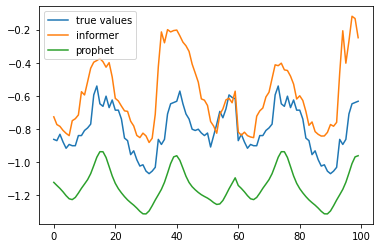

In [1084]:
plt.plot(trues1[:100], label="true values");
plt.plot(inf_pred1[:100], label="informer");
plt.plot(fb_pred1[:100], label="prophet");
plt.legend();

## Amazon stock price dataset

In [216]:
# source https://www.kaggle.com/praxitelisk/financial-time-series-datasets

In [35]:
amzn = pd.read_csv('data/AMZN.csv')
amzn.rename(columns={'Date':'ds', 'Adj Close':'y'}, inplace=True)
amzn.head(3)

,ds,y
0,5/15/1997,1.958333
1,5/16/1997,1.729167
2,5/19/1997,1.708333


In [36]:
s = StandardScaler() 
s.fit(amzn['y'])
amzn['y'] = s.transform(amzn['y'])
len(amzn)

5088

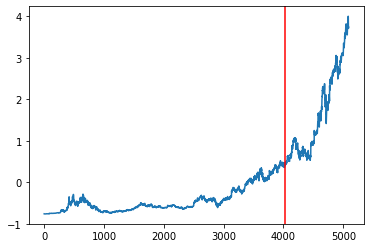

In [37]:
plt.plot(amzn['y'])
plt.axvline(4021, color='r')
amzn_cut = amzn[amzn.index>4021]
#fb1.changepoints.index[list(fb1.changepoints_t).index(fb1.changepoints_t.max())]
#fb1 = Prophet()
#fb1.fit(amzn_train)

In [38]:
enc_in=1 # encoder embedder input length
dec_in=1 # decoder embedder input length
c_out=1 # output length
seq_len=196 # length of Informer encoder
label_len=48 # start token length of Informer decoder
out_len=60 # prediction length

attn = 'prob' # full or prob [type of attention layer]
epochs = 6 # number of epochs
learning_rate = 0.0001 # initial learning rate
batch_size = 16
dropout = 0.05 # dropout proportion
d_model = 512 # dimesnsion of model
n_heads = 8 # number of heads
e_layers = 3 # num of encoder layers
d_layers = 2 # num of decoder layers
d_ff = 2048 # dimension of fully connected nets
factor = 5 # attention factor
freq = 'd' # frequency of a timeseries [d, h]
patience = 3 # early stopping patience

In [39]:
device = get_device()
m_amzn = Informer(enc_in, dec_in, c_out, seq_len, label_len, out_len, 
                factor, d_model, n_heads, e_layers, d_layers, d_ff, 
                dropout=0.05, attn='prob', embed='fixed', freq=freq, activation='gelu', 
                output_attention=False, distil=True).to(device)
train_loader = DataLoader(UnivarDataset(amzn, freq='d'), batch_size, shuffle=True)
vali_loader = DataLoader(UnivarDataset(amzn, freq='d', flag=1), batch_size)
train(m_amzn, train_loader, vali_loader, epochs, out_len, label_len, batch_size, learning_rate)

Epoch: 1 cost time: 25.30019235610962
train loss: 0.03803063544666854, vali loss: 0.14421460032463074
Updating learning rate to 0.0001
Epoch: 2 cost time: 26.106446027755737
train loss: 0.013991380860506865, vali loss: 0.130536288022995
Updating learning rate to 5e-05
Epoch: 3 cost time: 25.637758255004883
train loss: 0.00790975588202383, vali loss: 0.07748033106327057
Updating learning rate to 2.5e-05
Epoch: 4 cost time: 25.639933347702026
train loss: 0.005743292143771028, vali loss: 0.11882911622524261
Updating learning rate to 1.25e-05
EarlyStopping counter: 1 out of 3
Epoch: 5 cost time: 25.69048833847046
train loss: 0.004871369786677438, vali loss: 0.0849965512752533
Updating learning rate to 6.25e-06
EarlyStopping counter: 2 out of 3
Epoch: 6 cost time: 25.3539936542511
train loss: 0.004598920568667945, vali loss: 0.10093750059604645
Updating learning rate to 3.125e-06
EarlyStopping counter: 3 out of 3
Early stopping


In [235]:
# testing on Amzon stockprice dataset
test_amzn = UnivarDataset(amzn, freq='d', flag=2)
amzn_train = amzn[:int(len(amzn)*0.9)]

fb_amzn = Prophet(uncertainty_samples=50)
fb_amzn.fit(amzn_train)

prophet_preds_1 = []
for i in range(100):
    proph_pred = fb_amzn.predict(test_amzn.get_df(i))
    prophet_preds_1.append(proph_pred['yhat'])

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [237]:
len(prophet_preds_1)

100

In [223]:
test_loader = DataLoader(UnivarDataset(amzn, freq='d', flag=2), batch_size=1, shuffle=False, drop_last=True)
p,t = test(m_amzn, test_loader, out_len, label_len)

test shape: (450, 1, 60, 1) (450, 1, 60, 1)
test shape: (450, 60, 1) (450, 60, 1)
mse:3.3957302570343018, mae:1.7622854709625244


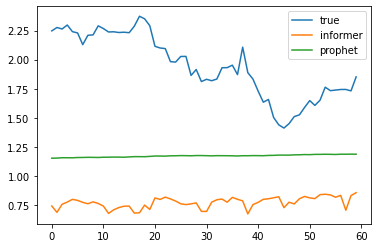

In [238]:
k = 90
plt.plot(t[k].flatten(), label='true')
plt.plot(p[k].flatten(), label='informer')
plt.plot(prophet_preds_1[k], label='prophet')
plt.legend();

In [1184]:
fb_pred2 = np.array(prophet_preds_1).reshape(-1, )
inf_pred2 = p[:100].reshape(-1, )
trues2 = t[:100].reshape(-1, )

In [1185]:
print(MSE(fb_pred2, trues2))
MSE(inf_pred2, trues2)

0.7401779334344769


1.5920494

# Global climate change data 

In [233]:
# source https://data.world/data-society/global-climate-change-data

In [165]:
temps = pd.read_csv('data/temps.csv')

In [166]:
temps.isnull().sum()

dt                                              0
LandAverageTemperature                         12
LandAverageTemperatureUncertainty              12
LandMaxTemperature                           1200
LandMaxTemperatureUncertainty                1200
LandMinTemperature                           1200
LandMinTemperatureUncertainty                1200
LandAndOceanAverageTemperature               1200
LandAndOceanAverageTemperatureUncertainty    1200
dtype: int64

In [167]:
temps = temps[temps.columns[:2]]
temps = temps.rename(columns={'dt':'ds','LandAverageTemperature':'y'})
temps=temps.fillna(0)
s = StandardScaler() 
s.fit(temps['y'])
temps['y'] = s.transform(temps['y'])

In [168]:
temps.head(3)

,ds,y
0,1750-01-01,-1.205824
1,1750-02-01,-1.194695
2,1750-03-01,-0.617135


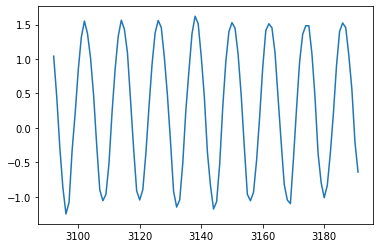

In [169]:
plt.plot(temps['y'].iloc[-100:]);

In [170]:
enc_in=1 # encoder embedder input length
dec_in=1 # decoder embedder input length
c_out=1 # output length
seq_len=96 # length of Informer encoder
label_len=48 # start token length of Informer decoder
out_len=60 # prediction length

attn = 'prob' # full or prob [type of attention layer]
epochs = 6 # number of epochs
learning_rate = 0.0001 # initial learning rate
batch_size = 32
dropout = 0.05 # dropout proportion
d_model = 512 # dimesnsion of model
n_heads = 8 # number of heads
e_layers = 3 # num of encoder layers
d_layers = 2 # num of decoder layers
d_ff = 2048 # dimension of fully connected nets
factor = 5 # attention factor
freq = 'm' # frequency of a timeseries [d, h]
patience = 3 # early stopping patience

In [171]:
device = get_device()
m_temp = Informer(enc_in, dec_in, c_out, seq_len, label_len, out_len, 
                factor, d_model, n_heads, e_layers, d_layers, d_ff, 
                dropout=0.05, attn='prob', embed='fixed', freq=freq, activation='gelu', 
                output_attention=False, distil=True).to(device)
train_loader = DataLoader(UnivarDataset(temps, freq='m'), batch_size, shuffle=True)
vali_loader = DataLoader(UnivarDataset(temps, freq='m', flag=1), batch_size)
train(m_temp, train_loader, vali_loader, epochs, out_len, label_len, batch_size, learning_rate)

Epoch: 1 cost time: 9.686855554580688
train loss: 0.5200519343217214, vali loss: 0.03259773179888725
Updating learning rate to 0.0001
Epoch: 2 cost time: 9.679893016815186
train loss: 0.06431399767597516, vali loss: 0.024324659258127213
Updating learning rate to 5e-05
Epoch: 3 cost time: 9.702021360397339
train loss: 0.051254260738690695, vali loss: 0.022127680480480194
Updating learning rate to 2.5e-05
Epoch: 4 cost time: 9.697391033172607
train loss: 0.04808065836628278, vali loss: 0.01706533506512642
Updating learning rate to 1.25e-05
Epoch: 5 cost time: 9.73042345046997
train loss: 0.04685815552870432, vali loss: 0.018989434465765953
Updating learning rate to 6.25e-06
EarlyStopping counter: 1 out of 3
Epoch: 6 cost time: 9.704275846481323
train loss: 0.04616082015136878, vali loss: 0.01682240702211857
Updating learning rate to 3.125e-06


In [190]:
test_loader = DataLoader(UnivarDataset(temps, freq='m', flag=2), batch_size=1, shuffle=False, drop_last=True)
p_temp, t_temp = test(m_temp, test_loader, out_len, label_len)

test shape: (261, 1, 60, 1) (261, 1, 60, 1)
test shape: (261, 60, 1) (261, 60, 1)
mse:0.03177155554294586, mae:0.1475590318441391


In [197]:
# testing on Amzon stockprice dataset
test_temp = UnivarDataset(temps, freq='m', flag=2)
temp_train = temps[:int(len(temps)*0.9)]

fb_temp = Prophet(uncertainty_samples=50)
fb_temp.fit(temp_train)

prophet_preds_2 = []
for i in range(100):
    proph_pred = fb_temp.predict(test_temp.get_df(i))
    prophet_preds_2.append(proph_pred['yhat'])

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [198]:
len(prophet_preds_2)

100

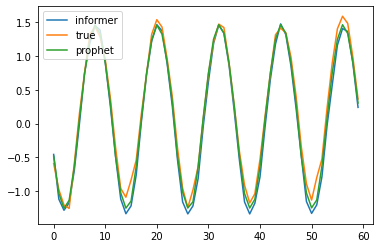

In [244]:
k = 54
plt.plot(p_temp[k].flatten(), label='informer');
plt.plot(t_temp[k].flatten(), label='true');
plt.plot(prophet_preds_2[k], label='prophet');
plt.legend(loc='upper left');

In [201]:
fb_pred3 = np.array(prophet_preds_2).reshape(-1, )
inf_pred3 = p_temp[:100].reshape(-1, )
trues3 = t_temp[:100].reshape(-1, )

In [202]:
print(MSE(fb_pred3, trues3))
MSE(inf_pred3, trues3)

0.010840630064495448


0.0273314

## ARIMA 

In [204]:
import pmdarima as pm

In [216]:
arima_amzn = pm.auto_arima(amzn['y'], seasonal=True, m=12)
forecasts = arima_amzn.predict(60)  

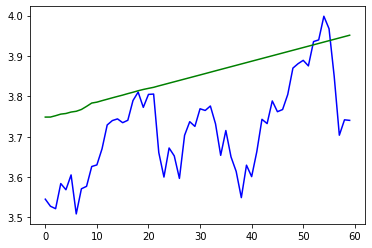

In [218]:
plt.plot(amzn['y'][-60:].values, c='blue')
plt.plot(forecasts, c='green')
plt.show()

In [205]:
arima_temp = pm.auto_arima(temps['y'], seasonal=True, m=12)
forecasts = arima_temp.predict(60)  

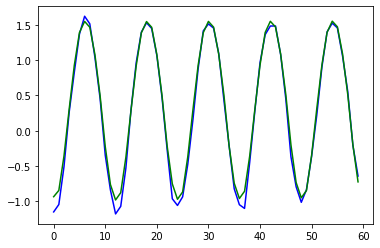

In [212]:
plt.plot(temps['y'][-60:].values, c='blue')
plt.plot(forecasts, c='green')
plt.show()

In [215]:
MSE(forecasts, temps['y'][-60:].values)

0.008394601050303515